# 1. Neural Networks

<img src='https://miro.medium.com/max/1063/0*u-AnjlGU9IxM5_Ju.png' width=500 height=400>

### 1. Neural Networks are a series of fully connected layers, which takes an input vector, applies the specified weights, and provides the output by applying the non-linearity function on that vector (obtained by applying the weights on the vector)

### 2. They improve the weights,by running backpropagation and improving the weights by using optimizer algorithm such as Adam, RMSProp, Stochastic Gradient Descent, etc.

### 3. However, while using this algorithm, one of the thing that needs to be accounted for, is the features present in the input layer. As for an example, while training the neural networks, the features are to be provided manually.

### 4. However, in case of Image Classification, when we need to predict the Image, the image need not be always in the structured format, it can be augmented, which means, the image can be just focused on a person, or it may be flipped horizontally,etc

### 5. Also, some images have very high dimension such as that of DSLR, and other such devices, so making a neural network that can classify such images, would take a lot of computation and lot of time.

### 6. So, in order to tackle such problems, the role of Convolutional Neural Nets come into picture.

# 2. Convolutional Neural Networks : NN for Image Recognition and Classification task

<img src='https://mk0analyticsindf35n9.kinstacdn.com/wp-content/uploads/2018/01/nural-network-05-770x433.jpg'>


# Reason for the use of CNNs:

### * One of the reason why CNN are hugely popular is because of their architecture — the best thing is there is no need of feature extraction. The system learns to do feature extraction and the core concept of CNN is, it uses convolution of image and filters to generate invariant features which are passed on to the next layer. 

### * The features in next layer are convoluted with different filters to generate more invariant and abstract features and the process continues till one gets final feature / output (let say face of X) which is invariant to occlusions.

# 2.a Convolutional 2D layer

<img src='https://miro.medium.com/max/464/0*e-SMFTzO8r7skkpc'>

### The convolution operation is one of the fundamental building blocks of a convolutional neural network. And, the convolution operation has an important role to play in the edge detection.
## For understanding it better, <a href='https://www.youtube.com/watch?v=f0t-OCG79-U'>Click here</a>

<img src='https://media5.datahacker.rs/2018/11/conv_3_neg30.png'>


# 2.b Max Pooling

### Max pooling is done to in part to help over-fitting by providing an abstracted form of the representation. As well, it reduces the computational cost by reducing the number of parameters to learn and provides basic translation invariance to the internal representation.
<img src='https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-10-at-3-38-39-am.png' width=600 height =400>

# 3 Code Part

## 3.1 Importing the Libraries

In [1]:
import numpy as np                      # For Scientific Computations
import pandas as pd                     # For Data Ananlysis
import os                               # For directly transferring the Data to/fro  from any directories
import cv2                              # For Image Augmentation and Displaying the Image
import matplotlib.pyplot as plt         # For Plotting the Diagrams
from tqdm import tqdm_notebook as tqdm  # For fancy display of the training
from sklearn.utils import shuffle       # For Shuffling the dataset

from keras import applications          # Useful for loading the already pretrained model
from keras import optimizers            # Optimizers
from keras.utils import to_categorical  # Converts a class vector (integers) to binary class matrix.
from keras.models import Sequential, Model, load_model  # For Model generating, loading and Saving
from keras.layers import Dropout, Flatten, Dense  # Flatten, Dense and Dropout
from keras.preprocessing.image import ImageDataGenerator   # A useful library, which we will be seeing 
from keras.callbacks import ModelCheckpoint  # For checkpointing the model, for a specified accuracy

Using TensorFlow backend.


In [2]:
# Creating a datafram which contains the path of the image and the category of the image (in terms of number i.e 0 for cat,etc)

foldernames = os.listdir('/kaggle/input/animals10/raw-img')
categories = []
files = []
i = 0
for k, folder in enumerate(foldernames):
    filenames = os.listdir("../input/animals10/raw-img/" + folder);
    for file in filenames:
        files.append("../input/animals10/raw-img/" + folder + "/" + file)
        categories.append(k)
        
df = pd.DataFrame({
    'filename': files,
    'category': categories
})
train_df = pd.DataFrame(columns=['filename', 'category'])
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:500,:])

train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

,filename,category
0,../input/animals10/raw-img/gallina/OIP--NVRWoI...,0
1,../input/animals10/raw-img/gallina/OIP-vz05Tbc...,0
2,../input/animals10/raw-img/gallina/OIP-Fj38EPj...,0
3,../input/animals10/raw-img/gallina/OIP-3C0nKeP...,0
4,../input/animals10/raw-img/gallina/OIP-kOTOTot...,0
...,...,...
4995,../input/animals10/raw-img/scoiattolo/OIP-M2ak...,9
4996,../input/animals10/raw-img/scoiattolo/OIP-i787...,9
4997,../input/animals10/raw-img/scoiattolo/OIP-zpZ5...,9
4998,../input/animals10/raw-img/scoiattolo/OIP-m5By...,9


In [3]:
y = train_df['category']
x = train_df['filename']
y = train_df['category']

x, y = shuffle(x, y, random_state=8)         # Randomly shuffling the dataframe, so as to improvise the accuracy of the model on unseen data

In [4]:
# Image Augmentation

def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

images = []
with tqdm(total=len(train_df)) as pbar:
    for i, file_path in enumerate(train_df.filename.values):
        #read image
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)             # Converting BGR to RGB Image , default is in BGR form

        #resize
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px 
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

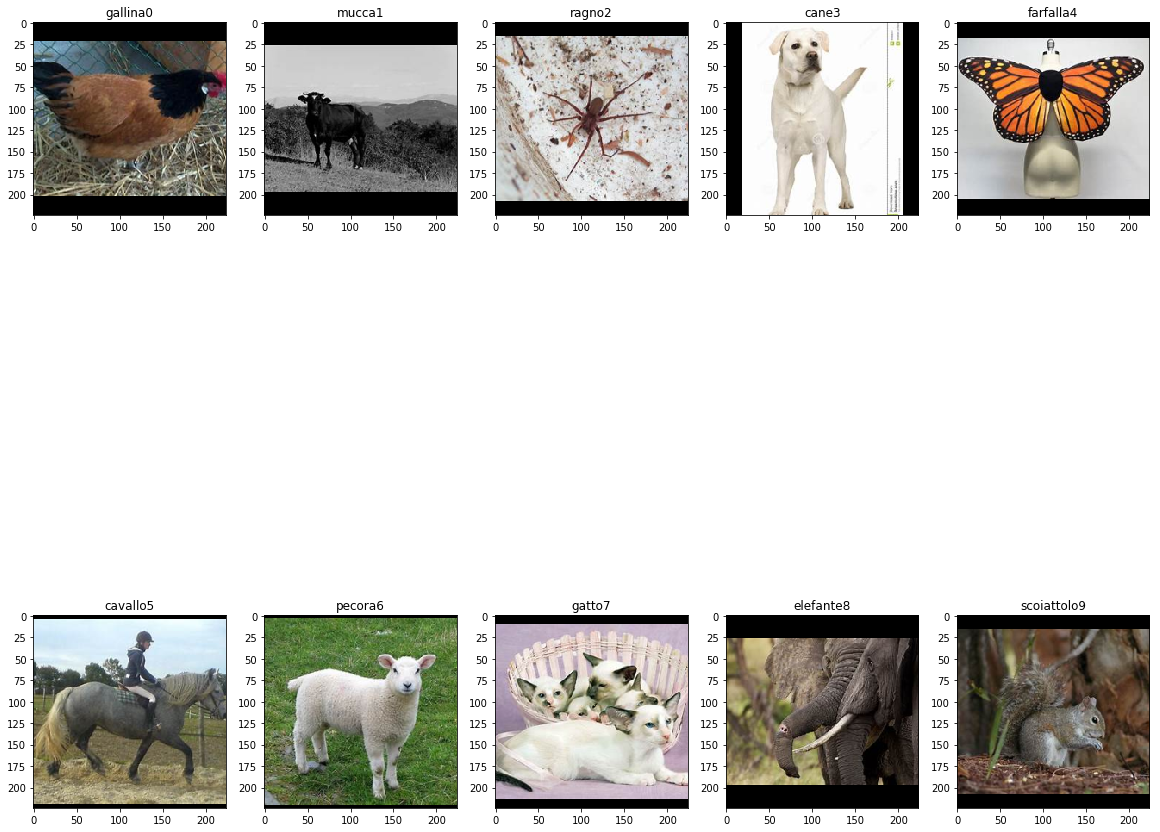

In [5]:
# Plotting some of the images of our training dataset

rows,cols = 2,5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
for i in range(10):
    path = train_df[train_df.category == i].values[2]
    # image = cv2.imread(path[0])/
    axes[i//cols, i%cols].set_title(path[0].split('/')[-2] + str(path[1]))
    axes[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [6]:
data_num = len(y)
random_index = np.random.permutation(data_num)       # Creating a random list of number from 0 to len(y) - 1, useful for shuffling

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle)                              # Converting images into Numpy Array
y = np.array(y_shuffle)                              # Labels or Class
val_split_num = int(round(0.2*len(y)))               
x_train = x[val_split_num:]                          # Converting into Training Data and Test Data
y_train = y[val_split_num:]
x_test = x[:val_split_num] 
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)
y_train = to_categorical(y_train)                    # Categorical Data
y_test = to_categorical(y_test)                      # Categorical Data

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

img_rows, img_cols, img_channel = 224, 224, 3
name_animal = []
for i in range(10):
    path = train_df[train_df.category == i].values[2]
    if path[0].split('/')[-2] == 'scoiattolo':
        name_animal.append('squirrel')
    elif path[0].split('/')[-2] == 'cavallo':
        name_animal.append('horse')
    elif path[0].split('/')[-2] == 'farfalla':
        name_animal.append('butterfly')
    elif path[0].split('/')[-2] == 'mucca':
        name_animal.append('cow')
    elif path[0].split('/')[-2] == 'gatto':
        name_animal.append('cat')
    elif path[0].split('/')[-2] == 'pecora':
        name_animal.append('sheep')
    elif path[0].split('/')[-2] == 'gallina':
        name_animal.append('chicken')
    elif path[0].split('/')[-2] == 'elefante':
        name_animal.append('elephant')
    elif path[0].split('/')[-2] == 'ragno':
        name_animal.append('spider')
    elif path[0].split('/')[-2] == 'cane':
        name_animal.append('dog')

x_train (4000, 224, 224, 3)
y_train (4000,)
x_test (1000, 224, 224, 3)
y_test (1000,)


In [7]:
# Importing the already designed Model, means the model has already defined all the convolutional layers, max pooling layers, and dimensions of those layers
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

# add model will be added to the last part, where the input from the base_model will be used to predict the class of the image
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(10, activation='softmax'))

# Combining the base_model and add_model to make the final model
model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

#Optimizers - Stochastic Gradient Descent, with specified learning parameters and momentum

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

# ImageDataGenerator 

<img src='https://miro.medium.com/max/600/1*wUDuWchsNha2u9egWQCikg.png'>

In [8]:
batch_size = 32                       # Specifying the batch size, which means after 32 images, the correction or the back propagation will be mage
epochs = 50                           # Number of Epochs

# ImageDataGenerator
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)


history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc')]
)

Epoch 1/50
125/125 [==============================] - 65s 517ms/step - loss: 0.3340 - accuracy: 0.8995 - val_loss: 0.3175 - val_accuracy: 0.9000
Epoch 2/50
125/125 [==============================] - 60s 482ms/step - loss: 0.3159 - accuracy: 0.9000 - val_loss: 0.3070 - val_accuracy: 0.9000
Epoch 3/50
125/125 [==============================] - 60s 481ms/step - loss: 0.3048 - accuracy: 0.9000 - val_loss: 0.2929 - val_accuracy: 0.9000
Epoch 4/50
125/125 [==============================] - 60s 479ms/step - loss: 0.2908 - accuracy: 0.9003 - val_loss: 0.2755 - val_accuracy: 0.9006
Epoch 5/50
125/125 [==============================] - 60s 479ms/step - loss: 0.2729 - accuracy: 0.9018 - val_loss: 0.2511 - val_accuracy: 0.9042
Epoch 6/50
125/125 [==============================] - 60s 476ms/step - loss: 0.2504 - accuracy: 0.9069 - val_loss: 0.2264 - val_accuracy: 0.9135
Epoch 7/50
125/125 [==============================] - 60s 480ms/step - loss: 0.2223 - accuracy: 0.9150 - val_loss: 0.1966 - val_ac

CNN: Epochs=50, Train accuracy=0.98830, Validation accuracy=0.97990


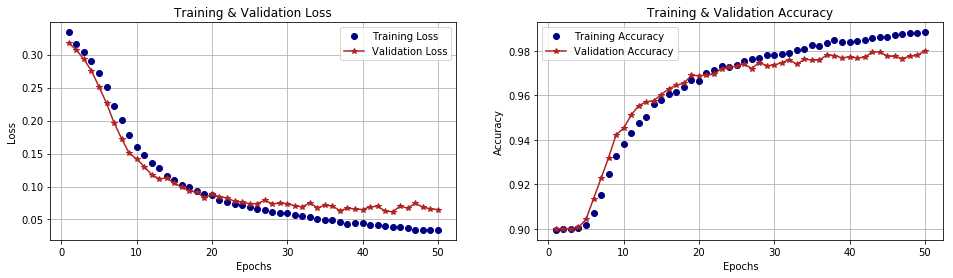

In [9]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
show_plots(history.history)

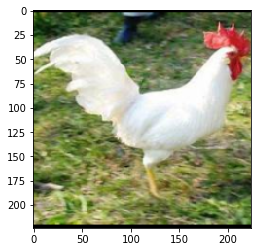

Actual  : chicken
Predict : chicken


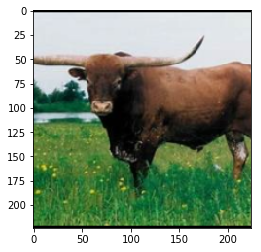

Actual  : cow
Predict : cow


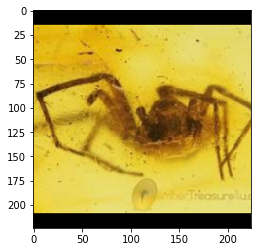

Actual  : spider
Predict : spider


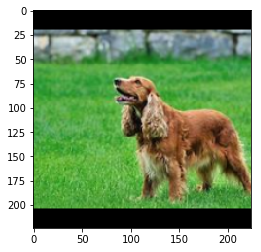

Actual  : dog
Predict : cow


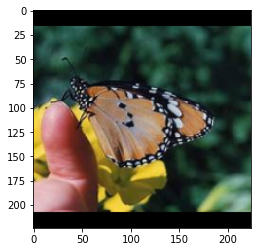

Actual  : butterfly
Predict : butterfly


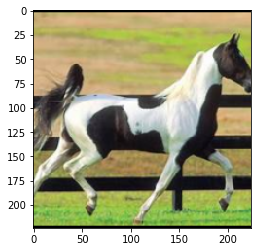

Actual  : horse
Predict : horse


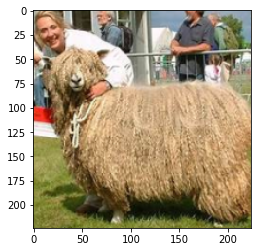

Actual  : sheep
Predict : chicken


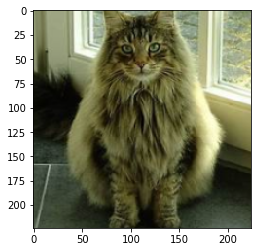

Actual  : cat
Predict : cat


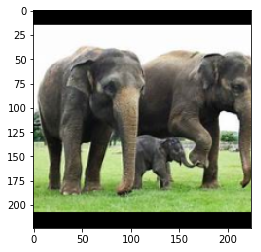

Actual  : elephant
Predict : cow


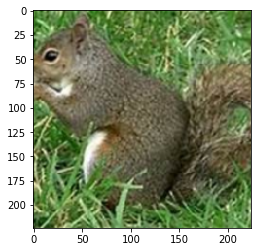

Actual  : squirrel
Predict : chicken


In [10]:
test_images = []
j = 39 # change this to get different images
for i in range(10):
    path = train_df[train_df.category == i].values[j]
    a = images[train_df[train_df.filename == path[0]].index[0]]
    img = np.array(a)
    img = img[:, :, ::-1].copy() 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = centering_image(cv2.resize(img, dsize=tile_size))
    img = img[16:240, 16:240]
    test_images.append(img)

test_images = np.array(test_images).reshape(-1,224,224,3)
something = model.predict(test_images)
animals = name_animal
i = 0
for pred in something:
    path = train_df[train_df.category == i].values[2]
    plt.imshow(test_images[i])
    plt.show()
    print('Actual  :', animals[i])
    print('Predict :', animals[np.where(pred.max() == pred)[0][0]])
    i += 1
